In [1]:
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import zipfile
import tensorflow as tf
from tqdm import tqdm
from keras.models import Model 
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers import Input
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.models import Sequential
from keras.layers import Dense,concatenate
from keras.layers import Reshape
from keras.layers import Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import UpSampling2D
from keras.layers import ReLU
from keras.layers.advanced_activations import LeakyReLU
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from keras import backend as K
from PIL import Image
import xml.etree.ElementTree as ET

Using TensorFlow backend.


In [2]:
# Constants and Directories
SEED = 4249
np.random.seed(SEED)
random_dim = 256
ROOT_DIR = '../input/'
IMAGES_DIR = ROOT_DIR + 'all-dogs/all-dogs/'
BREEDS_DIR = ROOT_DIR + 'annotation/Annotation/'

# File Lists
IMAGES = os.listdir(IMAGES_DIR)
BREEDS = os.listdir(BREEDS_DIR) 

# Summary
print('Total Images: {}'.format(len(IMAGES)))
print('Total Annotations: {}'.format(len(BREEDS)))

Total Images: 20579
Total Annotations: 120


In [3]:
def load_images():
    # Place holder for output 
    all_images = np.zeros((22250, 64, 64, 3))
    
    # Index
    index = 0
    
    for breed in BREEDS:
        for dog in os.listdir(BREEDS_DIR + breed):
            try: img = Image.open(IMAGES_DIR + dog + '.jpg') 
            except: continue  
                
            tree = ET.parse(BREEDS_DIR + breed + '/' + dog)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                bndbox = o.find('bndbox') 
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                
                # Determine each side
                xdelta = xmax - xmin
                ydelta = ymax - ymin
                
                # Take the mean of the sides
                w = int((xdelta + ydelta) / 2)
                
                # Filter out images where bounding box is below 64 pixels.
                # This filters out a couple of 100 images but prevents using low resolution images.
                if xdelta >= 64 and ydelta >= 64:
                    img2 = img.crop((xmin, ymin, xmin + w, ymin + w))
                    img2 = img2.resize((64, 64), Image.ANTIALIAS)
                    image = np.asarray(img2)
                    
                    #    # Normalize to range[-1, 1]
                    all_images[index,:] = (image.astype(np.float32) - 127.5)/127.5
                    
                    index += 1
        
                # Plot Status
                if index % 1000 == 0:
                    print('Processed Images: {}'.format(index))

    print('Total Processed Images: {}'.format(index))

    return all_images

In [4]:
real_images = load_images()

Processed Images: 1000
Processed Images: 2000
Processed Images: 3000
Processed Images: 4000
Processed Images: 5000
Processed Images: 6000
Processed Images: 7000
Processed Images: 8000
Processed Images: 9000
Processed Images: 10000
Processed Images: 11000
Processed Images: 12000
Processed Images: 13000
Processed Images: 14000
Processed Images: 15000
Processed Images: 16000
Processed Images: 17000
Processed Images: 18000
Processed Images: 19000
Processed Images: 20000
Processed Images: 21000
Total Processed Images: 21912


In [5]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 64
        self.img_cols = 64
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 16 * 16, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((16, 16, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self,X_train, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        #(X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 255
        #X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            #print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/mnist_%d.png" % epoch)
        plt.show()
        plt.close()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 17, 17, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 17, 17, 64)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 17, 17, 64)        0         
__________

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.453129, acc.: 40.62%] [G loss: 0.520168]


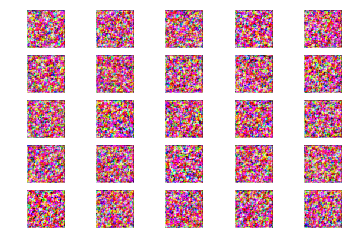

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6000 [D loss: 8.059048, acc.: 50.00%] [G loss: 13.472991]


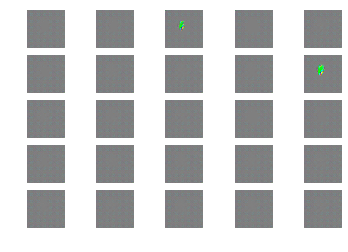

12000 [D loss: 8.059048, acc.: 50.00%] [G loss: 16.053841]


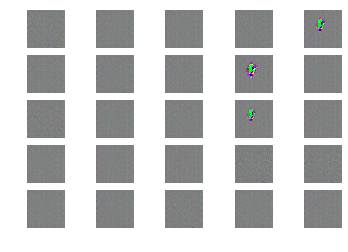

18000 [D loss: 8.059048, acc.: 50.00%] [G loss: 16.118095]


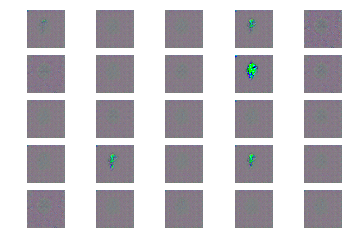

24000 [D loss: 8.059048, acc.: 50.00%] [G loss: 16.118095]


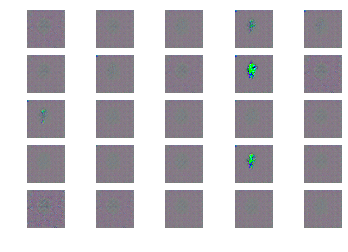

30000 [D loss: 8.059048, acc.: 50.00%] [G loss: 16.118095]


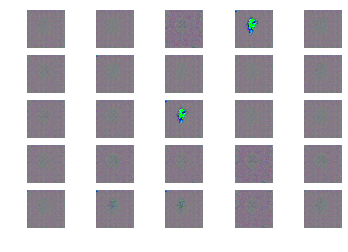

36000 [D loss: 8.059048, acc.: 50.00%] [G loss: 16.118095]


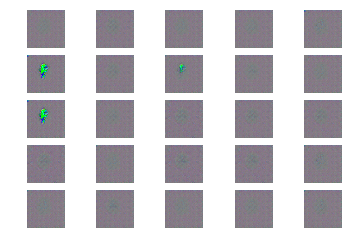

42000 [D loss: 8.059048, acc.: 50.00%] [G loss: 16.118095]


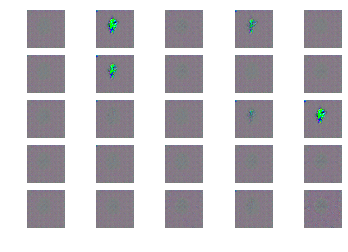

48000 [D loss: 8.059048, acc.: 50.00%] [G loss: 16.118095]


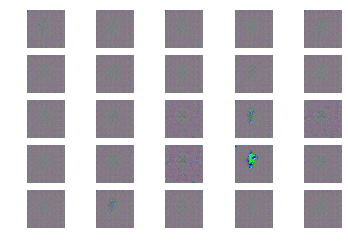

54000 [D loss: 8.059048, acc.: 50.00%] [G loss: 16.118095]


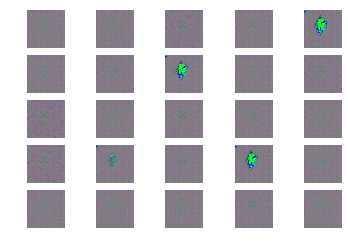

In [6]:
bigan = DCGAN()
bigan.train(real_images,epochs=60000, batch_size=32,save_interval=6000)    

In [7]:
# SAVE TO ZIP FILE NAMED IMAGES.ZIP
z = zipfile.PyZipFile('images.zip', mode='w')

for k in range(10000):
    img = bigan.generator.predict(np.random.normal(-1,1,(1,100))).reshape(64,64,3)
    img = Image.fromarray( img.astype('uint8') )
    f = str(k)+'.png'
    img.save(f,'PNG'); z.write(f); os.remove(f)
    #if k % 1000==0: print(k)
z.close()